# Tema 5: Clasificación y Mantenimiento Predictivo

## Objetivos del Notebook
En este notebook aprenderemos a:
- Cargar y explorar un dataset de mantenimiento predictivo industrial
- Realizar análisis exploratorio de datos (EDA) para entender las variables
- Preprocesar los datos eliminando columnas irrelevantes y codificando variables categóricas
- Dividir los datos en conjuntos de entrenamiento y prueba
- Escalar las características numéricas para mejorar el rendimiento del modelo
- Entrenar y evaluar modelos de clasificación (Regresión Logística y Random Forest)
- Interpretar los resultados y la importancia de las características

**Dataset:** AI4I 2020 Predictive Maintenance Dataset
**Problema:** Predecir fallos en maquinaria industrial antes de que ocurran

In [13]:
# Entorno Python con librerías de análisis preinstaladas
# Este entorno está definido por la imagen Docker de Kaggle: https://github.com/kaggle/docker-python
# Aquí cargamos algunos paquetes útiles

import numpy as np  # Álgebra lineal y operaciones numéricas
import pandas as pd  # Procesamiento de datos, manejo de CSV (ej: pd.read_csv)

# Los archivos de datos están disponibles en el directorio "../input/" (solo lectura)
# Por ejemplo, ejecutar esto (haciendo clic en run o presionando Shift+Enter) 
# listará todos los archivos en el directorio de entrada

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Puedes escribir hasta 20GB en el directorio actual (/kaggle/working/) 
# que se preserva como salida cuando creas una versión usando "Save & Run All" 
# También puedes escribir archivos temporales en /kaggle/temp/, 
# pero no se guardarán fuera de la sesión actual

## 1. Importación de Librerías

Importamos todas las librerías necesarias para el análisis y modelado:

In [14]:
import numpy as np  # Operaciones numéricas y matrices
import pandas as pd  # Manipulación y análisis de datos
import matplotlib.pyplot as plt  # Visualización de gráficos
import seaborn as sns  # Visualización estadística avanzada

# Librerías de Scikit-Learn para Machine Learning
from sklearn.model_selection import train_test_split  # División train/test
from sklearn.preprocessing import StandardScaler  # Normalización de datos
from sklearn.linear_model import LogisticRegression  # Modelo de regresión logística
from sklearn.ensemble import RandomForestClassifier  # Modelo Random Forest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Métricas de evaluación

# Ignorar advertencias para mantener el output limpio
import warnings
warnings.filterwarnings('ignore')

## 2. Carga y Exploración Inicial de Datos

Cargamos el dataset de mantenimiento predictivo y exploramos su estructura básica.

In [15]:
# Cargar el dataset desde Kaggle usando kagglehub
# Este dataset contiene información de sensores de máquinas industriales
# Instalar si es necesario: pip install kagglehub

%pip install kagglehub

import kagglehub

# Cargar la última versión del dataset de mantenimiento predictivo
# Especificamos el archivo CSV principal
path = kagglehub.dataset_download("stephanmatzka/predictive-maintenance-dataset-ai4i-2020")

import os
csv_file = os.path.join(path, "ai4i2020.csv")
df = pd.read_csv(csv_file)

# Mostrar las primeras 5 filas para entender la estructura de los datos
print("Primeras 5 filas del dataset:")
df.head()

Note: you may need to restart the kernel to use updated packages.


100%|██████████| 136k/136k [00:00<00:00, 544kB/s]

Extracting files...


Primeras 5 filas del dataset:


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [16]:
# Información general del dataset: tipos de datos, valores nulos, memoria
df.info()

# Estadísticas descriptivas de las columnas numéricas (media, desviación, min, max, etc.)
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


## 3. Análisis Exploratorio de Datos (EDA)

### 3.1 Distribución de la Variable Objetivo

Visualizamos la distribución de fallos en las máquinas para detectar desbalanceo de clases.

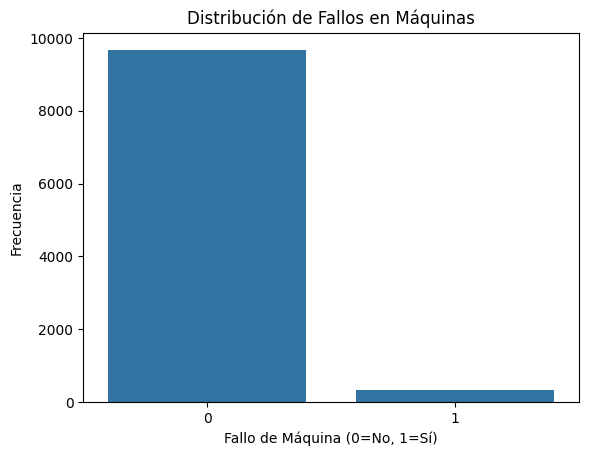

In [17]:
# Gráfico de barras para visualizar la distribución de fallos
# Si hay muchos más casos de una clase que de otra, el dataset está desbalanceado
sns.countplot(x='Machine failure', data=df)
plt.title("Distribución de Fallos en Máquinas")
plt.xlabel("Fallo de Máquina (0=No, 1=Sí)")
plt.ylabel("Frecuencia")
plt.show()

### 3.2 Matriz de Correlación

Analizamos las correlaciones entre variables numéricas para identificar relaciones lineales.

In [18]:
# Seleccionar solo las columnas numéricas para calcular correlaciones
# Las variables categóricas (como 'Type') no se incluyen automáticamente
numeric_df = df.select_dtypes(include=[np.number])

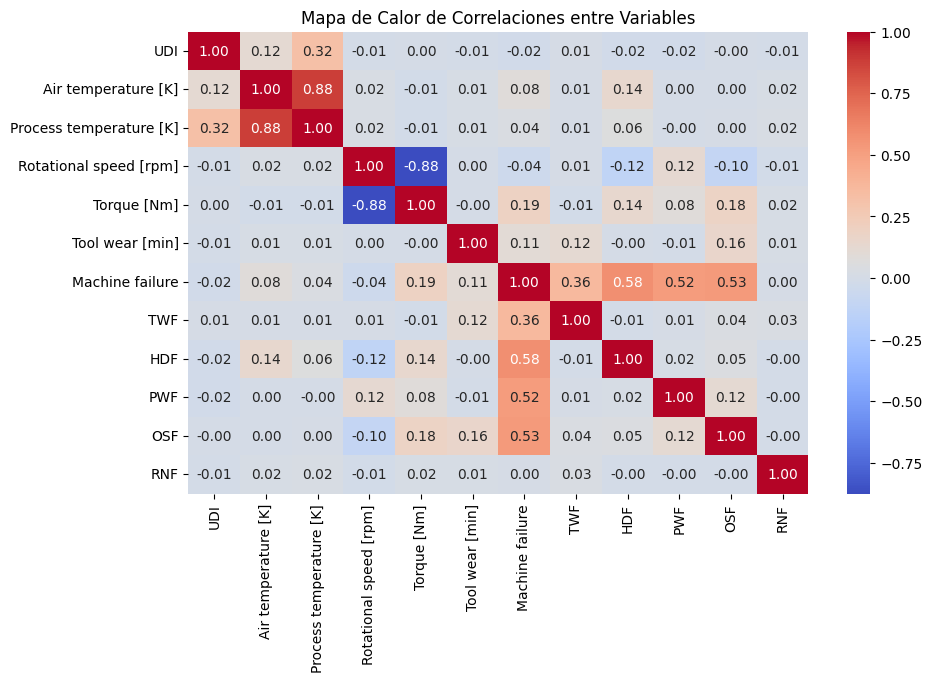

In [19]:
# Crear un mapa de calor (heatmap) de las correlaciones
# Valores cercanos a 1 o -1 indican fuerte correlación (positiva o negativa)
# Valores cercanos a 0 indican poca o ninguna correlación lineal
plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Mapa de Calor de Correlaciones entre Variables")
plt.show()

## 4. Preprocesamiento de Datos

### 4.1 Renombrar Columnas

Simplificamos el nombre de la columna objetivo para facilitar el código.

In [20]:
# Verificar los nombres actuales de todas las columnas
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

In [21]:
# Renombrar 'Machine failure' a 'failure' para simplificar
# inplace=True modifica el DataFrame original sin crear una copia
df.rename(columns={'Machine failure': 'failure'}, inplace=True)

In [22]:
# Verificar que el cambio se aplicó correctamente
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

### 4.2 Eliminar Columnas Irrelevantes

Eliminamos identificadores únicos (UDI, Product ID) que no aportan información predictiva.

In [23]:
X = df.drop('failure', axis=1)
y = df['failure']


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [25]:
# Eliminar 'UDI' (identificador único de datos) y 'Product ID' (identificador de producto)
# Estas columnas son solo identificadores y no tienen valor predictivo
df.drop(['UDI', 'Product ID'], axis=1, inplace=True)

### 4.3 Codificación de Variables Categóricas

Convertimos la columna 'Type' (tipo de máquina) de texto a valores numéricos.

In [26]:
# Mapear valores categóricos a numéricos:
# 'L' (Low) -> 0, 'M' (Medium) -> 1, 'H' (High) -> 2
# Esto permite que los algoritmos de ML procesen esta variable
df['Type'] = df['Type'].map({'L': 0, 'M': 1, 'H': 2})

### 4.4 Eliminar Columnas de Data Leakage

Eliminamos columnas que contienen información sobre el tipo específico de fallo, ya que esto crearía **data leakage** (filtración de información del futuro al modelo).

In [27]:
# Estas columnas indican el tipo específico de fallo (TWF, HDF, OSF, PWF, RNF)
# Si las dejamos, el modelo "haría trampa" al conocer el tipo de fallo antes de predecirlo
# TWF = Tool Wear Failure, HDF = Heat Dissipation Failure, OSF = Overstrain Failure
# PWF = Power Failure, RNF = Random Failures
leakage_cols = ['TWF', 'HDF', 'OSF', 'PWF', 'RNF']
df.drop(leakage_cols, axis=1, inplace=True)

## 5. Preparación de Datos para Modelado

### 5.1 Separación de Variables X (características) e y (objetivo)

In [28]:
# X contiene todas las características (features) excepto la variable objetivo
# y contiene la variable objetivo (failure: 0 = no fallo, 1 = fallo)
X = df.drop('failure', axis=1)
y = df['failure']

### 5.2 División en Conjunto de Entrenamiento y Prueba

Dividimos los datos en 80% entrenamiento y 20% prueba, manteniendo la proporción de clases (stratify).

In [29]:
from sklearn.model_selection import train_test_split

# test_size=0.2 -> 20% de datos para test, 80% para entrenamiento
# random_state=42 -> semilla aleatoria para reproducibilidad
# stratify=y -> mantiene la misma proporción de clases en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### 5.3 Escalado de Características

Normalizamos las variables para que tengan media 0 y desviación estándar 1. Esto mejora el rendimiento de muchos algoritmos, especialmente Regresión Logística.

In [30]:
from sklearn.preprocessing import StandardScaler

# Crear el escalador
scaler = StandardScaler()

# fit_transform: calcula la media y desviación en train, y transforma
X_train_scaled = scaler.fit_transform(X_train)

# transform: solo transforma test usando los parámetros calculados en train
# NUNCA usar fit_transform en test para evitar data leakage
X_test_scaled = scaler.transform(X_test)

## 6. Modelado y Evaluación

### 6.1 Regresión Logística

Entrenamos un modelo de Regresión Logística, que es un algoritmo de clasificación lineal.

In [31]:
# Crear el modelo de Regresión Logística
lr = LogisticRegression()

# Entrenar el modelo con los datos escalados de entrenamiento
lr.fit(X_train_scaled, y_train)

# Realizar predicciones sobre el conjunto de prueba
y_pred_lr = lr.predict(X_test_scaled)

# Evaluar el modelo
print("Precisión de Regresión Logística:", accuracy_score(y_test, y_pred_lr))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_lr))

Precisión de Regresión Logística: 0.9675

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1932
           1       0.64      0.10      0.18        68

    accuracy                           0.97      2000
   macro avg       0.80      0.55      0.58      2000
weighted avg       0.96      0.97      0.96      2000



### 6.2 Random Forest (Modelo Optimizado)

Entrenamos un modelo Random Forest con hiperparámetros ajustados y balance de clases.

Precisión en Test: 0.9735
Recall en Test: 0.7794117647058824

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1932
           1       0.58      0.78      0.67        68

    accuracy                           0.97      2000
   macro avg       0.79      0.88      0.83      2000
weighted avg       0.98      0.97      0.98      2000



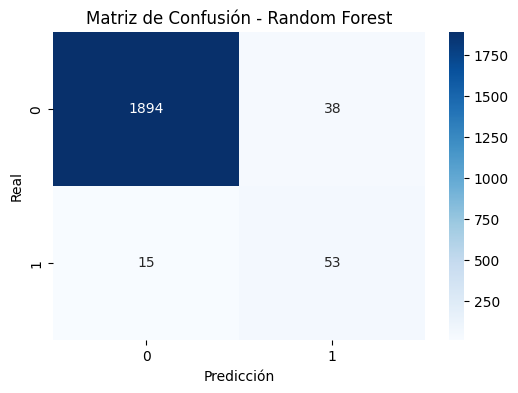

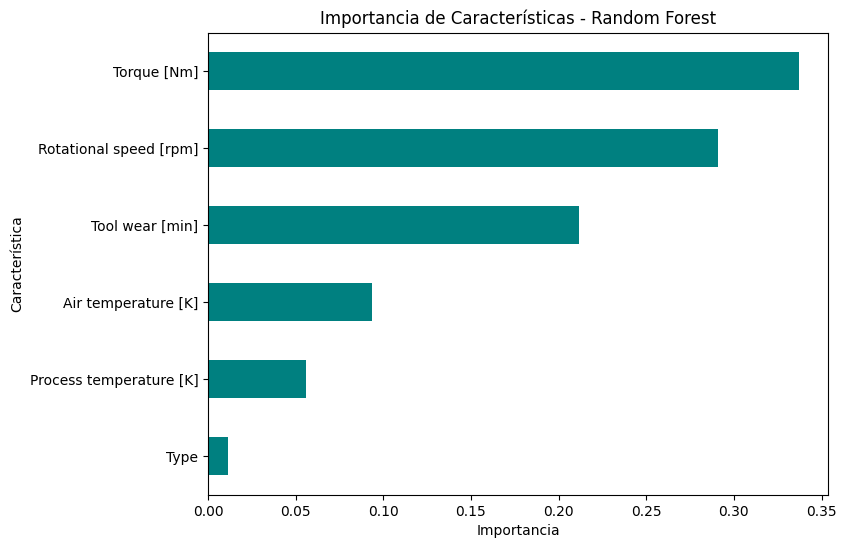

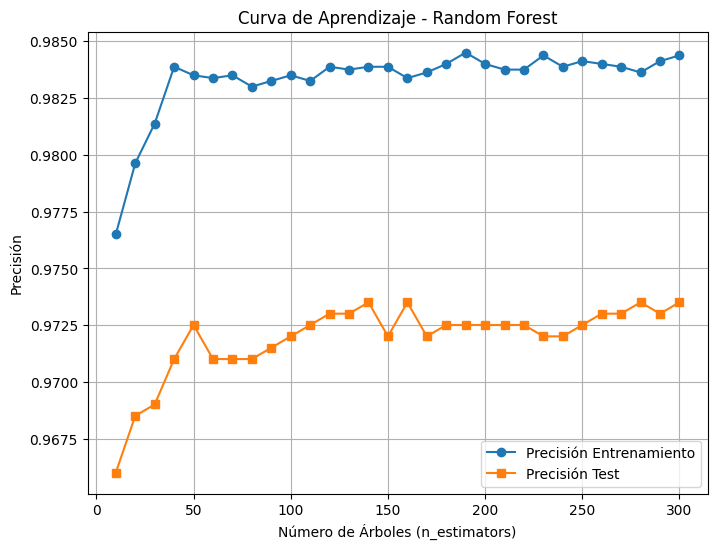

In [32]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Configurar el modelo Random Forest con hiperparámetros optimizados
rf_final = RandomForestClassifier(
    class_weight='balanced',  # Balance automático de clases desbalanceadas
    max_depth=10,  # Profundidad máxima de cada árbol (evita overfitting)
    min_samples_leaf=5,  # Mínimo de muestras en cada hoja (regularización)
    n_estimators=300,  # Número de árboles en el bosque
    random_state=42  # Semilla para reproducibilidad
)

# Entrenar el modelo con datos sin escalar (Random Forest no lo requiere)
rf_final.fit(X_train, y_train)

# Realizar predicciones
y_pred = rf_final.predict(X_test)

# --- Métricas de Evaluación ---
print("Precisión en Test:", accuracy_score(y_test, y_pred))
print("Recall en Test:", recall_score(y_test, y_pred))
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))

# --- Matriz de Confusión ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Random Forest")
plt.show()

# --- Importancia de Características ---
# Muestra qué variables tienen más peso en las predicciones del modelo
importances = pd.Series(rf_final.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(8,6))
importances.plot(kind='barh', color='teal')
plt.title("Importancia de Características - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.show()

# --- Curva de Aprendizaje ---
# Visualiza cómo cambia la precisión al aumentar el número de árboles
train_scores = []
test_scores = []
estimators_range = np.arange(10, 310, 10)  # n_estimators de 10 a 300

for n in estimators_range:
    rf_temp = RandomForestClassifier(
        n_estimators=n,
        max_depth=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42
    )
    rf_temp.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, rf_temp.predict(X_train)))
    test_scores.append(accuracy_score(y_test, rf_temp.predict(X_test)))

plt.figure(figsize=(8,6))
plt.plot(estimators_range, train_scores, label='Precisión Entrenamiento', marker='o')
plt.plot(estimators_range, test_scores, label='Precisión Test', marker='s')
plt.xlabel("Número de Árboles (n_estimators)")
plt.ylabel("Precisión")
plt.title("Curva de Aprendizaje - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

## 7. Análisis Adicional de Regresión Logística

### 7.1 Comparación Train vs Test

In [33]:
# Comparar el rendimiento del modelo en entrenamiento vs prueba
# Si train >> test, hay overfitting
# Si ambos son similares, el modelo generaliza bien
print("Precisión en Entrenamiento:", lr.score(X_train_scaled, y_train))
print("Precisión en Test:", lr.score(X_test_scaled, y_test))

Precisión en Entrenamiento: 0.970375
Precisión en Test: 0.9675


### 7.2 Validación Cruzada (Cross-Validation)

Evaluamos el Recall promedio usando validación cruzada de 5 pliegues (5-fold).

In [34]:
from sklearn.model_selection import cross_val_score

# Validación cruzada con 5 pliegues (cv=5)
# Scoring='recall' porque en mantenimiento predictivo es crucial detectar fallos (minimizar falsos negativos)
scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='recall')
print("Recall promedio (5-fold CV):", scores.mean())
print("Desviación estándar:", scores.std())

Recall promedio (5-fold CV): 0.1920538720538721
Desviación estándar: 0.060810206121902265


### 7.3 Coeficientes del Modelo

Los coeficientes indican la importancia y dirección del impacto de cada característica en la predicción.

In [35]:
# Mostrar los coeficientes ordenados de menor a mayor
# Coeficientes positivos -> aumentan la probabilidad de fallo
# Coeficientes negativos -> disminuyen la probabilidad de fallo
pd.Series(lr.coef_[0], index=X.columns).sort_values()

Process temperature [K]   -0.968394
Type                      -0.274071
Tool wear [min]            0.784366
Air temperature [K]        1.432976
Rotational speed [rpm]     2.015672
Torque [Nm]                2.714334
dtype: float64

## 8. Curva ROC y AUC

### 8.1 Curva ROC para Regresión Logística

La curva ROC (Receiver Operating Characteristic) muestra la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) para diferentes umbrales de clasificación. El área bajo la curva (AUC) resume el rendimiento del modelo en un solo número.

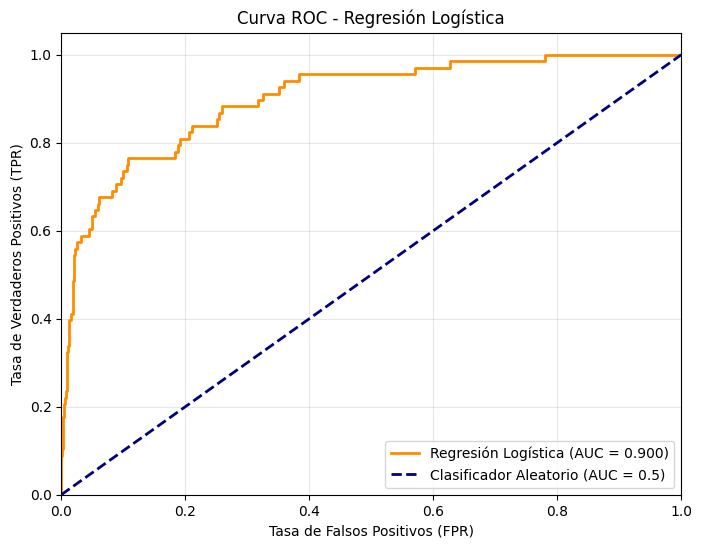


AUC-ROC Regresión Logística: 0.9003
Interpretación: AUC > 0.5 indica que el modelo es mejor que el azar.
AUC cercano a 1.0 indica excelente capacidad de discriminación.


In [36]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Obtener las probabilidades predichas para la clase positiva (fallo)
# predict_proba devuelve probabilidades para cada clase [prob_clase_0, prob_clase_1]
y_pred_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

# Calcular la curva ROC: False Positive Rate (FPR) y True Positive Rate (TPR)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_lr)

# Calcular el área bajo la curva (AUC)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Visualizar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, 
         label=f'Regresión Logística (AUC = {roc_auc_lr:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador Aleatorio (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"\nAUC-ROC Regresión Logística: {roc_auc_lr:.4f}")
print(f"Interpretación: AUC > 0.5 indica que el modelo es mejor que el azar.")
print(f"AUC cercano a 1.0 indica excelente capacidad de discriminación.")

### 8.2 Curva ROC para Random Forest

Ahora calculamos y visualizamos la curva ROC para el modelo Random Forest.

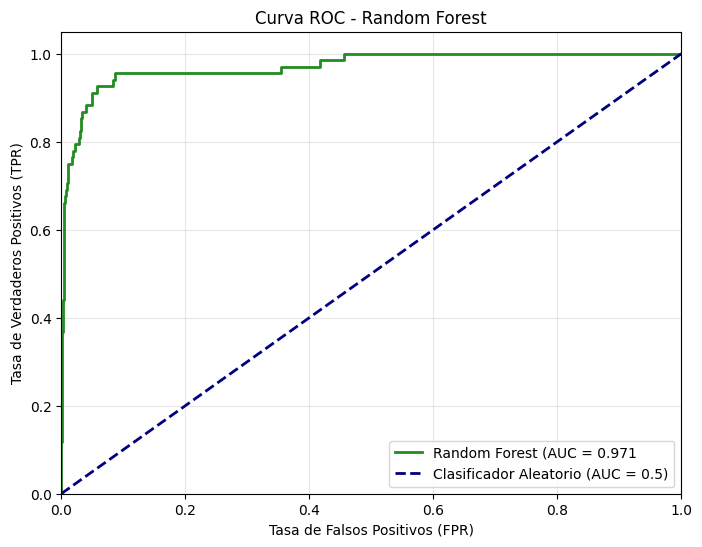


AUC-ROC Random Forest: 0.9712


In [37]:
# Obtener las probabilidades predichas para Random Forest
y_pred_proba_rf = rf_final.predict_proba(X_test)[:, 1]

# Calcular la curva ROC para Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Visualizar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='forestgreen', lw=2, 
         label=f'Random Forest (AUC = {roc_auc_rf:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador Aleatorio (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Random Forest')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"\nAUC-ROC Random Forest: {roc_auc_rf:.4f}")

### 8.3 Comparación de Curvas ROC

Visualizamos ambos modelos en la misma gráfica para comparar su rendimiento.

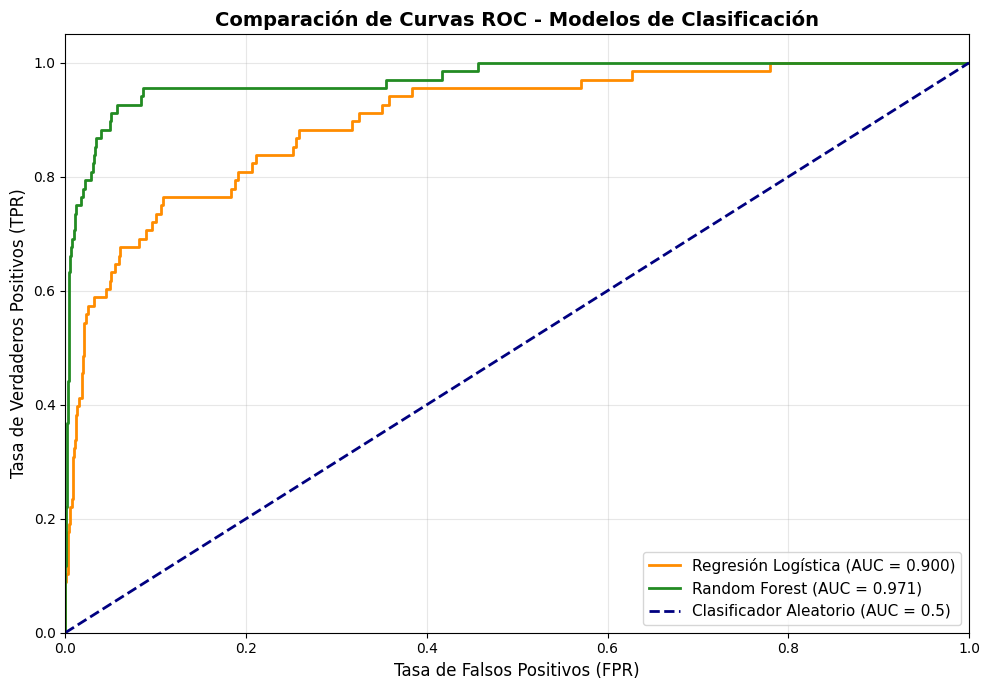


RESUMEN DE MÉTRICAS AUC-ROC
Regresión Logística:  AUC = 0.9003
Random Forest:        AUC = 0.9712

Mejor modelo según AUC: Random Forest
Diferencia en AUC: 0.0709

💡 Interpretación:
   - AUC = 0.5: Modelo no mejor que el azar
   - AUC = 0.7-0.8: Discriminación aceptable
   - AUC = 0.8-0.9: Discriminación excelente
   - AUC > 0.9: Discriminación excepcional


In [38]:
# Comparar ambas curvas ROC en la misma gráfica
plt.figure(figsize=(10, 7))

# Curva ROC para Regresión Logística
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, 
         label=f'Regresión Logística (AUC = {roc_auc_lr:.3f})')

# Curva ROC para Random Forest
plt.plot(fpr_rf, tpr_rf, color='forestgreen', lw=2, 
         label=f'Random Forest (AUC = {roc_auc_rf:.3f})')

# Línea de referencia (clasificador aleatorio)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Clasificador Aleatorio (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
plt.title('Comparación de Curvas ROC - Modelos de Clasificación', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Resumen de métricas AUC
print("\n" + "="*50)
print("RESUMEN DE MÉTRICAS AUC-ROC")
print("="*50)
print(f"Regresión Logística:  AUC = {roc_auc_lr:.4f}")
print(f"Random Forest:        AUC = {roc_auc_rf:.4f}")
print("="*50)
print(f"\nMejor modelo según AUC: {'Random Forest' if roc_auc_rf > roc_auc_lr else 'Regresión Logística'}")
print(f"Diferencia en AUC: {abs(roc_auc_rf - roc_auc_lr):.4f}")
print("\n💡 Interpretación:")
print("   - AUC = 0.5: Modelo no mejor que el azar")
print("   - AUC = 0.7-0.8: Discriminación aceptable")
print("   - AUC = 0.8-0.9: Discriminación excelente")
print("   - AUC > 0.9: Discriminación excepcional")

## Conclusiones

En este notebook hemos:

1. **Cargado y explorado** un dataset de mantenimiento predictivo industrial
2. **Preprocesado** los datos eliminando columnas irrelevantes y de data leakage
3. **Codificado** variables categóricas para uso en ML
4. **Dividido** los datos en train/test manteniendo la proporción de clases
5. **Escalado** características para mejorar el rendimiento de Regresión Logística
6. **Entrenado** dos modelos: Regresión Logística y Random Forest
7. **Evaluado** los modelos usando múltiples métricas (Accuracy, Recall, F1-Score)
8. **Visualizado** matrices de confusión, importancia de características y curvas de aprendizaje

**Resultado clave:** Random Forest con `class_weight='balanced'` logra mejor rendimiento al manejar el desbalanceo de clases, crucial en mantenimiento predictivo donde detectar fallos (alta Recall) es prioritario.